In [ ]:
!wget https://raw.githubusercontent.com/leetae04kr/file_to_use/main/날씨예측/daegu_humidity.csv
!wget https://raw.githubusercontent.com/leetae04kr/file_to_use/main/날씨예측/daegu_sunshine.csv
!wget https://raw.githubusercontent.com/leetae04kr/file_to_use/main/날씨예측/daegu_temp.csv
!wget https://raw.githubusercontent.com/leetae04kr/file_to_use/main/날씨예측/daegu_wind.csv

--2022-11-29 07:01:20--  https://raw.githubusercontent.com/leetae04kr/all_files/main/colab/colab%EC%82%AC%EC%9A%A9%20%ED%8C%8C%EC%9D%BC/%EB%82%A0%EC%94%A8%EC%98%88%EC%B8%A1/daegu_humidity.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1136434 (1.1M) [text/plain]
Saving to: ‘daegu_humidity.csv’

daegu_humidity.csv  100%[===================>]   1.08M  --.-KB/s    in 0.06s   

2022-11-29 07:01:21 (17.0 MB/s) - ‘daegu_humidity.csv’ saved [1136434/1136434]

--2022-11-29 07:01:21--  https://raw.githubusercontent.com/leetae04kr/all_files/main/colab/colab%EC%82%AC%EC%9A%A9%20%ED%8C%8C%EC%9D%BC/%EB%82%A0%EC%94%A8%EC%98%88%EC%B8%A1/daegu_sunshine.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.1

# 대구시 기온

## 데이터 불러오기(최고기온,최저기온,일교차)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
datasetfile="/content/daegu_temp.csv"
wind=pd.read_csv(datasetfile, encoding='latin-1')
wind.head()

,place code,place,date,average_temp,high_temp,high_time,low_temp,low_time,day_temp_range
0,\t\t143,´ë±¸,1940.1.1,0.0,7.4,15:45,-4.6,8:25,12.0
1,\t\t143,´ë±¸,1940.1.2,-0.4,7.6,15:32,-6.6,7:15,14.2
2,\t\t143,´ë±¸,1940.1.3,0.9,7.2,13:45,-5.7,7:00,12.9
3,\t\t143,´ë±¸,1940.1.4,5.7,14.6,14:45,-6.0,6:40,20.6
4,\t\t143,´ë±¸,1940.1.5,5.2,11.9,14:16,-0.1,23:45,12.0


In [ ]:
wind.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30291 entries, 0 to 30290
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   place code      30291 non-null  object 
 1   place           30283 non-null  object 
 2   date            30283 non-null  object 
 3   average_temp    30281 non-null  float64
 4   high_temp       30280 non-null  float64
 5   high_time       30241 non-null  object 
 6   low_temp        30281 non-null  float64
 7   low_time        30242 non-null  object 
 8   day_temp_range  30280 non-null  float64
dtypes: float64(4), object(5)
memory usage: 2.1+ MB


##최고기온 예측

###훈련 및 예측

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
(6041, 4)
(6041, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20)                1760      
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
808/808 [==============================] - 6s 5ms/step - loss: 0.0188
Epoch 2/100
808/808 [==============================] - 3s 4ms/step - loss: 0.0056
Epoch 3/100
808/808 [==============================] - 3s 4ms/step - loss: 0.0055
Epoch 4/100
808/808 [==============================] - 6s 7ms/step - loss: 0.0054
Epoch 5/100
808/808 [=====

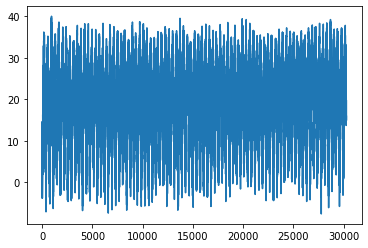

In [ ]:
head='high_temp'
#wind.info()
wind[head].plot()

#367*0.8=293.6
train=wind.loc[:24233, [head]]
test=wind.loc[24233:, [head]]

ax=train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test'])

from sklearn.preprocessing import MinMaxScaler

sc=MinMaxScaler()

train_sc=sc.fit_transform(train)
test_sc=sc.transform(test)

#train_sc

train_sc_df=pd.DataFrame(train_sc, columns=[head], index=train.index)
test_sc_df=pd.DataFrame(test_sc, columns=[head], index=test.index)
train_sc_df.head()

for s in range(1, 5):
  train_sc_df['shift_{}'.format(s)]=train_sc_df[head].shift(s)
  test_sc_df['shift_{}'.format(s)]=test_sc_df[head].shift(s)

train_sc_df.head(5)

X_train=train_sc_df.dropna().drop(head, axis=1)
y_train=train_sc_df.dropna()[[head]]

X_test=test_sc_df.dropna().drop(head, axis=1)
y_test=test_sc_df.dropna()[[head]]

#X_test.head()

print(type(X_train))
print(type(X_test))

print(X_test.shape)
print(y_test.shape)

X_train_t=X_train.values.reshape(X_train.shape[0], 4, 1)
X_test_t=X_test.values.reshape(X_test.shape[0],4,1)


from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping

K.clear_session()

model=Sequential()
model.add(LSTM(20, input_shape=(4,1))) # (timestep, feature)
model.add(Dense(1)) # output=1
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)

model.fit(X_train_t, y_train, epochs=100, batch_size=30, verbose=1, callbacks=[early_stop])

train_sc_df.describe()

import matplotlib.pyplot as plt

y_pred=model.predict(X_test_t, batch_size=30)
plt.scatter(y_test, y_pred)




###예측 및 시각화

In [ ]:
input_date=1
next_day=input_date-1
next_temp=y_pred[next_day]*23.39135740125
print(input_date,'일 뒤의 예상 온도는',next_temp,'도 입니다')

1 일 뒤의 예상 온도는 [13.990608] 도 입니다


In [ ]:
input_date=5
next_day=input_date-1
next_temp=y_pred[next_day]*23.39135740125
print(input_date,'일 뒤의 예상 온도는',next_temp,'도 입니다')

5 일 뒤의 예상 온도는 [15.224972] 도 입니다


In [ ]:
input_date=100
next_day=input_date-1
next_temp=y_pred[next_day]*23.39135740125
print(input_date,'일 뒤의 예상 온도는',next_temp,'도 입니다')

100 일 뒤의 예상 온도는 [20.204483] 도 입니다


31일 예측
61일 예측
301일 예측


<Figure size 432x288 with 0 Axes>

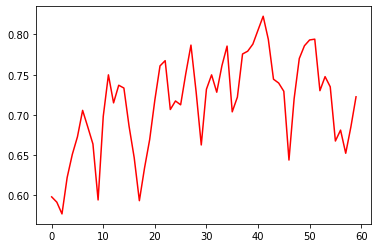

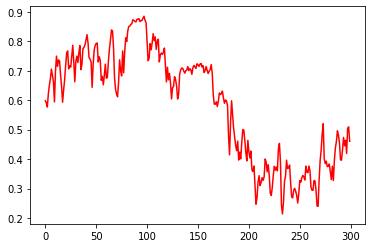

<Figure size 432x288 with 0 Axes>

In [ ]:
#한달치 예측한 결과 그래프
print('31일 예측')
plt.plot(y_pred[0:30],'black')
plt.figure()
print('61일 예측')
plt.plot(y_pred[0:60],'r')
plt.figure()
print('301일 예측')
plt.plot(y_pred[0:300],'r')
plt.figure()

# 대구시 풍속

## 데이터 불러오기(평균풍속(m/s)	최대풍속(m/s)	최대풍속풍향(deg)최대순간풍속(m/s)	최대순간풍속풍향(deg))

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
datasetfile="/content/daegu_wind.csv"
wind=pd.read_csv(datasetfile, encoding='latin-1')
wind.head()

,place_num,place,day,Average_wind_speed,Maximum_wind_speed,Maximum_wind_direction (deg),Maximum_wind_speed_time,Maximum_instantaneous_wind_speed (m/s),Maximum_instantaneous_wind_direction,Maximum_instantaneous_wind_speed_time
0,\t\t143,´ë±¸,1960.6.1,5.8,9.0,90.0,15:50,10.2,90.0,15:45
1,\t\t143,´ë±¸,1960.6.2,1.7,5.7,180.0,19:30,6.2,180.0,19:00
2,\t\t143,´ë±¸,1960.6.3,3.4,9.3,270.0,13:12,11.6,270.0,13:05
3,\t\t143,´ë±¸,1960.6.4,3.9,11.0,320.0,1:20,13.0,320.0,1:07
4,\t\t143,´ë±¸,1960.6.5,4.9,11.7,250.0,14:10,15.3,250.0,14:12


In [ ]:
wind.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22830 entries, 0 to 22829
Data columns (total 10 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   place_num                               22830 non-null  object 
 1   place                                   22826 non-null  object 
 2   day                                     22826 non-null  object 
 3   Average_wind_speed                      22820 non-null  float64
 4   Maximum_wind_speed                      22822 non-null  float64
 5   Maximum_wind_direction (deg)            22823 non-null  float64
 6   Maximum_wind_speed_time                 22822 non-null  object 
 7   Maximum_instantaneous_wind_speed (m/s)  22821 non-null  float64
 8   Maximum_instantaneous_wind_direction    22821 non-null  float64
 9   Maximum_instantaneous_wind_speed_time   22819 non-null  object 
dtypes: float64(5), object(5)
memory usage: 1.7+ MB


## 평균풍속 예측

###훈련 및 예측

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
(4538, 4)
(4538, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20)                1760      
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
609/609 [==============================] - 8s 7ms/step - loss: 0.0161
Epoch 2/100
609/609 [==============================] - 3s 4ms/step - loss: 0.0142
Epoch 3/100
609/609 [==============================] - 3s 4ms/step - loss: 0.0139
Epoch 4/100
609/609 [==============================] - 4s 6ms/step - loss: 0.0138
Epoch 5/100
609/609 [=====

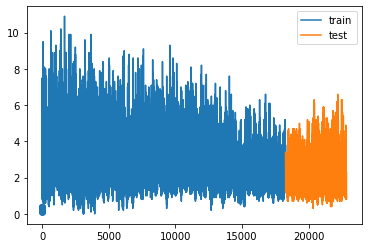

In [ ]:
head='Average_wind_speed'
#wind.info()
wind[head].plot()

#367*0.8=293.6
train=wind.loc[:18264, [head]]
test=wind.loc[18264:, [head]]

ax=train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test'])

from sklearn.preprocessing import MinMaxScaler

sc=MinMaxScaler()

train_sc=sc.fit_transform(train)
test_sc=sc.transform(test)

#train_sc

train_sc_df=pd.DataFrame(train_sc, columns=[head], index=train.index)
test_sc_df=pd.DataFrame(test_sc, columns=[head], index=test.index)
train_sc_df.head()

for s in range(1, 5):
  train_sc_df['shift_{}'.format(s)]=train_sc_df[head].shift(s)
  test_sc_df['shift_{}'.format(s)]=test_sc_df[head].shift(s)

train_sc_df.head(5)

X_train=train_sc_df.dropna().drop(head, axis=1)
y_train=train_sc_df.dropna()[[head]]

X_test=test_sc_df.dropna().drop(head, axis=1)
y_test=test_sc_df.dropna()[[head]]

#X_test.head()

print(type(X_train))
print(type(X_test))

print(X_test.shape)
print(y_test.shape)

X_train_t=X_train.values.reshape(X_train.shape[0], 4, 1)
X_test_t=X_test.values.reshape(X_test.shape[0],4,1)


from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping

K.clear_session()

model=Sequential()
model.add(LSTM(20, input_shape=(4,1))) # (timestep, feature)
model.add(Dense(1)) # output=1
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)

model.fit(X_train_t, y_train, epochs=100, batch_size=30, verbose=1, callbacks=[early_stop])

train_sc_df.describe()

import matplotlib.pyplot as plt

y_pred=model.predict(X_test_t, batch_size=30)
plt.scatter(y_test, y_pred)




###예측 및 시각화

In [ ]:
test.head(10)

,Average_wind_speed
18264,1.3
18265,1.5
18266,1.6
18267,2.3
18268,3.4
18269,2.9
18270,2.5
18271,2.0
18272,2.7
18273,2.5


In [ ]:
1.3/train_sc[0]+1.5/train_sc[1]+1.6/train_sc[2]+2.3/train_sc[3]+3.4/train_sc[4]+2.9/train_sc[5]+2.5/train_sc[6]+2/train_sc[7]+2.7/train_sc[8]+2.5/train_sc[9]

array([73.03136256])

In [ ]:
input_date=1
next_day=input_date-1
next_temp=y_pred[next_day]*7.303136256
print(input_date,'일 뒤의 예상 평균풍속은',next_temp,'m/s 입니다')

1 일 뒤의 예상 평균풍속은 [1.554224] m/s 입니다


In [ ]:
input_date=10
next_day=input_date-1
next_temp=y_pred[next_day]*7.303136256
print(input_date,'일 뒤의 예상 평균풍속은',next_temp,'m/s 입니다')

10 일 뒤의 예상 평균풍속은 [1.6755208] m/s 입니다


In [ ]:
input_date=100
next_day=input_date-1
next_temp=y_pred[next_day]*7.303136256
print(input_date,'일 뒤의 예상 평균풍속은',next_temp,'m/s 입니다')

100 일 뒤의 예상 평균풍속은 [1.4391012] m/s 입니다


31일 예측
61일 예측
301일 예측


<Figure size 432x288 with 0 Axes>

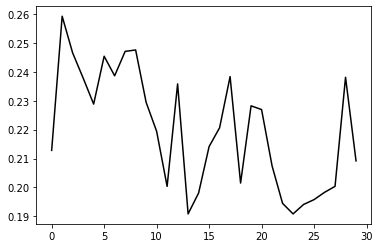

<Figure size 432x288 with 0 Axes>

In [ ]:
#한달치 예측한 결과 그래프
print('31일 예측')
plt.plot(y_pred[0:30],'black')
plt.figure()
print('61일 예측')
plt.plot(y_pred[0:60],'r')
plt.figure()
print('301일 예측')
plt.plot(y_pred[0:300],'b')
plt.figure()

#대구시 습도

## 데이터 불러오기 (평균습도(%rh) 최저습도(%rh))

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
datasetfile="/content/daegu_humidity.csv"
wind=pd.read_csv(datasetfile, encoding='latin-1')
wind.head()

,place_num,place,date,Average_Humidity,Lowest_humidity
0,\t\t143,´ë±¸,1924.1.1,55.7,21.0
1,\t\t143,´ë±¸,1924.1.2,46.0,23.0
2,\t\t143,´ë±¸,1924.1.3,64.7,34.0
3,\t\t143,´ë±¸,1924.1.4,58.3,26.0
4,\t\t143,´ë±¸,1924.1.5,45.7,26.0


In [ ]:
wind.info

<bound method DataFrame.info of       place_num place        date  Average_Humidity  Lowest_humidity
0       \t\t143  ´ë±¸    1924.1.1              55.7             21.0
1       \t\t143  ´ë±¸    1924.1.2              46.0             23.0
2       \t\t143  ´ë±¸    1924.1.3              64.7             34.0
3       \t\t143  ´ë±¸    1924.1.4              58.3             26.0
4       \t\t143  ´ë±¸    1924.1.5              45.7             26.0
...         ...   ...         ...               ...              ...
36125   \t\t143  ´ë±¸  2022.11.27              46.1             23.0
36126   \t\t143  ´ë±¸  2022.11.28              73.9             44.0
36127      \t\t   NaN         NaN               NaN              NaN
36128        \t   NaN         NaN               NaN              NaN
36129        \t   NaN         NaN               NaN              NaN

[36130 rows x 5 columns]>

## 평균습도 예측

### 훈련 및 예측

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
(7178, 4)
(7178, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20)                1760      
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
965/965 [==============================] - 7s 5ms/step - loss: 0.0246
Epoch 2/100
965/965 [==============================] - 5s 5ms/step - loss: 0.0190
Epoch 3/100
965/965 [==============================] - 4s 4ms/step - loss: 0.0184
Epoch 4/100
965/965 [==============================] - 5s 5ms/step - loss: 0.0179
Epoch 5/100
965/965 [=====

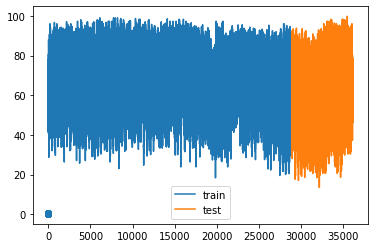

In [ ]:
head='Average_Humidity'
#wind.info()
wind[head].plot()

#367*0.8=293.6
train=wind.loc[:28940, [head]]
test=wind.loc[28940:, [head]]

ax=train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test'])

from sklearn.preprocessing import MinMaxScaler

sc=MinMaxScaler()

train_sc=sc.fit_transform(train)
test_sc=sc.transform(test)

#train_sc

train_sc_df=pd.DataFrame(train_sc, columns=[head], index=train.index)
test_sc_df=pd.DataFrame(test_sc, columns=[head], index=test.index)
train_sc_df.head()

for s in range(1, 5):
  train_sc_df['shift_{}'.format(s)]=train_sc_df[head].shift(s)
  test_sc_df['shift_{}'.format(s)]=test_sc_df[head].shift(s)

train_sc_df.head(5)

X_train=train_sc_df.dropna().drop(head, axis=1)
y_train=train_sc_df.dropna()[[head]]

X_test=test_sc_df.dropna().drop(head, axis=1)
y_test=test_sc_df.dropna()[[head]]

#X_test.head()

print(type(X_train))
print(type(X_test))

print(X_test.shape)
print(y_test.shape)

X_train_t=X_train.values.reshape(X_train.shape[0], 4, 1)
X_test_t=X_test.values.reshape(X_test.shape[0],4,1)


from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping

K.clear_session()

model=Sequential()
model.add(LSTM(20, input_shape=(4,1))) # (timestep, feature)
model.add(Dense(1)) # output=1
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)

model.fit(X_train_t, y_train, epochs=100, batch_size=30, verbose=1, callbacks=[early_stop])

train_sc_df.describe()

import matplotlib.pyplot as plt

y_pred=model.predict(X_test_t, batch_size=30)
plt.scatter(y_test, y_pred)




### 예측 및 시각화


In [ ]:
test.head(10)

,Average_Humidity
28940,51.6
28941,45.5
28942,34.4
28943,41.3
28944,63.6
28945,48.9
28946,51.0
28947,50.1
28948,55.8
28949,41.3


In [ ]:
51.6/train_sc[0]+45.5/train_sc[1]+34.4/train_sc[2]+41.3/train_sc[3]+63.6/train_sc[4]

array([574.3681772])

In [ ]:
input_date=1
next_day=input_date-1
next_temp=y_pred[next_day]*114.87363544
print(input_date,'일 뒤의 예상 평균습도은',next_temp,'%rh 입니다')

1 일 뒤의 예상 평균습도은 [43.42778] %rh 입니다


In [ ]:
input_date=10
next_day=input_date-1
next_temp=y_pred[next_day]*114.87363544
print(input_date,'일 뒤의 예상 평균습도은',next_temp,'%rh 입니다')

10 일 뒤의 예상 평균습도은 [67.37939] %rh 입니다


In [ ]:
input_date=150
next_day=input_date-1
next_temp=y_pred[next_day]*114.87363544
print(input_date,'일 뒤의 예상 평균습도은',next_temp,'%rh 입니다')

150 일 뒤의 예상 평균습도은 [79.25261] %rh 입니다


31일 예측
61일 예측
365일 예측


<Figure size 432x288 with 0 Axes>

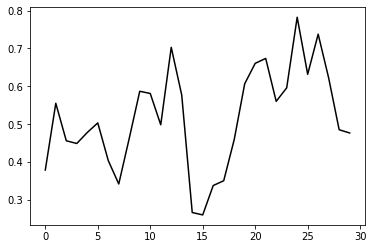

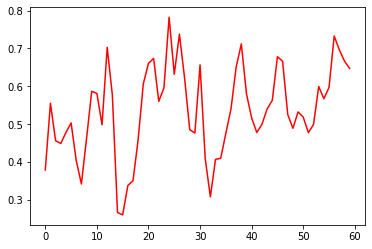

<Figure size 432x288 with 0 Axes>

In [ ]:
#한달치 예측한 결과 그래프
print('31일 예측')
plt.plot(y_pred[0:30],'black')
plt.figure()
print('61일 예측')
plt.plot(y_pred[0:60],'r')
plt.figure()
print('365일 예측')
plt.plot(y_pred[0:364],'b')
plt.figure()

# 대구시 일조량

## 데이터 불러오기기 (일조합(hr))

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
datasetfile="/content/daegu_sunshine.csv"
wind=pd.read_csv(datasetfile, encoding='latin-1')
wind.head()

,date,sunshine
0,1915.1.1,5.4
1,1915.1.2,7.2
2,1915.1.3,7.8
3,1915.1.4,7.9
4,1915.1.5,8.3


In [ ]:
wind.info

<bound method DataFrame.info of              date  sunshine
0        1915.1.1       5.4
1        1915.1.2       7.2
2        1915.1.3       7.8
3        1915.1.4       7.9
4        1915.1.5       8.3
...           ...       ...
39409  2022.11.24       3.9
39410  2022.11.25       8.1
39411  2022.11.26       8.3
39412  2022.11.27       8.1
39413  2022.11.28       1.5

[39414 rows x 2 columns]>

##일조량 예측

### 훈련 및 예측

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
(7854, 4)
(7854, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20)                1760      
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1045/1045 [==============================] - 7s 4ms/step - loss: 0.0750
Epoch 2/100
1045/1045 [==============================] - 4s 4ms/step - loss: 0.0700
Epoch 3/100
1045/1045 [==============================] - 5s 5ms/step - loss: 0.0693
Epoch 4/100
1045/1045 [==============================] - 6s 6ms/step - loss: 0.0691
Epoch 5/100
1045/1

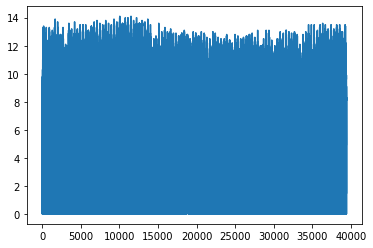

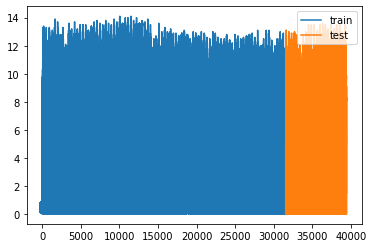

In [ ]:
head='sunshine'
#wind.info()
wind[head].plot()

#367*0.8=293.6
train=wind.loc[:31531, [head]]
test=wind.loc[31531:, [head]]

ax=train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test'])

from sklearn.preprocessing import MinMaxScaler

sc=MinMaxScaler()

train_sc=sc.fit_transform(train)
test_sc=sc.transform(test)

#train_sc

train_sc_df=pd.DataFrame(train_sc, columns=[head], index=train.index)
test_sc_df=pd.DataFrame(test_sc, columns=[head], index=test.index)
train_sc_df.head()

for s in range(1, 5):
  train_sc_df['shift_{}'.format(s)]=train_sc_df[head].shift(s)
  test_sc_df['shift_{}'.format(s)]=test_sc_df[head].shift(s)

train_sc_df.head(5)

X_train=train_sc_df.dropna().drop(head, axis=1)
y_train=train_sc_df.dropna()[[head]]

X_test=test_sc_df.dropna().drop(head, axis=1)
y_test=test_sc_df.dropna()[[head]]

#X_test.head()

print(type(X_train))
print(type(X_test))

print(X_test.shape)
print(y_test.shape)

X_train_t=X_train.values.reshape(X_train.shape[0], 4, 1)
X_test_t=X_test.values.reshape(X_test.shape[0],4,1)


from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping

K.clear_session()

model=Sequential()
model.add(LSTM(20, input_shape=(4,1))) # (timestep, feature)
model.add(Dense(1)) # output=1
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)

model.fit(X_train_t, y_train, epochs=100, batch_size=30, verbose=1, callbacks=[early_stop])

train_sc_df.describe()

import matplotlib.pyplot as plt

y_pred=model.predict(X_test_t, batch_size=30)
plt.scatter(y_test, y_pred)




###예측 및 시각화

In [ ]:
input_date=1
next_day=input_date-1
next_temp=y_pred[next_day]*10.921034636
print(input_date,'일 뒤의 예상 일조합은',next_temp,'hr 입니다')

100 일 뒤의 예상 일조합은 [3.8980727] hr 입니다


In [ ]:
input_date=10
next_day=input_date-1
next_temp=y_pred[next_day]*10.921034636
print(input_date,'일 뒤의 예상 일조합은',next_temp,'hr 입니다')

10 일 뒤의 예상 일조합은 [7.264548] hr 입니다


In [ ]:
input_date=100
next_day=input_date-1
next_temp=y_pred[next_day]*10.921034636
print(input_date,'일 뒤의 예상 일조합은',next_temp,'hr 입니다')

100 일 뒤의 예상 일조합은 [3.8980727] hr 입니다


In [ ]:
input_date=180
next_day=input_date-1
next_temp=y_pred[next_day]*10.921034636
print(input_date,'일 뒤의 예상 일조합은',next_temp,'hr 입니다')

180 일 뒤의 예상 일조합은 [3.321819] hr 입니다


31일 예측
61일 예측
365일 예측


<Figure size 432x288 with 0 Axes>

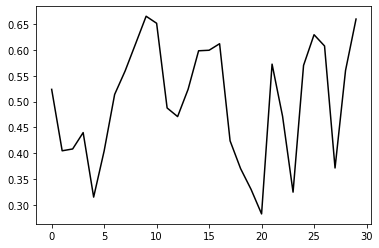

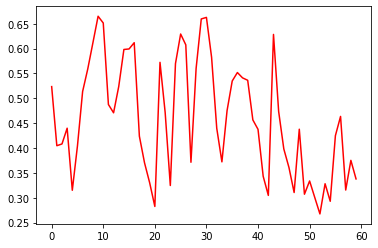

<Figure size 432x288 with 0 Axes>

In [ ]:
#한달치 예측한 결과 그래프
print('31일 예측')
plt.plot(y_pred[0:30],'black')
plt.figure()
print('61일 예측')
plt.plot(y_pred[0:60],'r')
plt.figure()
print('365일 예측')
plt.plot(y_pred[0:364],'b')
plt.figure()